### Reads in the balanced extracted fields and plots the PDFs of the sim, extraction and the posterior

For Fig. 11 of the balanced extraction paper 

Testing the extraction of vorticity from the posterior

In [1]:
import numpy as np
import os, pickle
from scipy.sparse.linalg import eigsh
import JWS_SWOT_toolbox as swot
import matplotlib.pyplot as plt
import scipy.linalg as la
import h5py
import xarray as xr

PICKLES = "../pickles"
KARIN_NA_PATH = f"{PICKLES}/karin_NA_tmean.pkl"  # where SWOT data is held
NADIR_NA_PATH = f"{PICKLES}/nadir_NA_tmean.pkl"  # where SWOT data is held

def load(p):
    with open(p, "rb") as f:
        return pickle.load(f)

def path_nonoise(km):  # "ground truth"
    return f"{PICKLES}/balanced_extraction_synth_NA_tmean_sm_{km}km_nonoise.pkl"

def path_withnoise(km):  # extracted balanced field
    return f"{PICKLES}/balanced_extraction_synth_NA_tmean_sm_{km}km.pkl"

def finite_flat(*arrays):
    outs = []
    for a in arrays:
        v = np.asarray(a, dtype=float).ravel()
        outs.append(v[np.isfinite(v)])
    return outs

t = 40
km = 2

karin = load(KARIN_NA_PATH)
dx = float(karin.dx_km) * 1e3
dy = float(karin.dy_km) * 1e3
lat_1d = np.asarray(karin.lat)[0, :, 0]  # for gvort

ht_sim = np.asarray(load(path_nonoise(km)), dtype=float)
ht_ext = np.asarray(load(path_withnoise(km)), dtype=float)
T, ny, nx = ht_ext.shape

L_PATH = f"{PICKLES}/posterior_balanced_extraction_synth_NA_tmean_sm_{km}km.pkl"
C = load(L_PATH)
Lfac, lower = la.cho_factor(C + np.eye(C.shape[0]) * 1.0e-10, lower=True) 
Ltri = np.tril(Lfac)

# posterior sample: x ~ N(mu, C) with C ≈ L L^T
mu = (ht_ext[t] * 100).ravel()  
r = C.shape[1]
z = np.random.randn(r)  
ht_post   = (mu + Ltri @ z).reshape(ny, nx) / 100.0  # meters

post_vort = swot.compute_geostrophic_vorticity(ht_post,   dx, dy, lat_1d, order=2)
sim_vort  = swot.compute_geostrophic_vorticity(ht_sim[t], dx, dy, lat_1d, order=2)
ext_vort  = swot.compute_geostrophic_vorticity(ht_ext[t], dx, dy, lat_1d, order=2)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


┌ Warning: CHOLMOD version incompatibility
│ 
│ Julia was compiled with CHOLMOD version 4.0.4. It is
│ currently linked with version 5.3.1.
│ This might cause Julia to terminate when working with
│ sparse matrix factorizations, e.g. solving systems of
│ equations with \.
│ 
│ It is recommended that you use Julia with the same major
│ version of CHOLMOD as the one used during the build, or
│ download the generic binaries from www.julialang.org,
│ which ship with the correct versions of all dependencies.
└ @ SparseArrays.CHOLMOD ~/miniconda3/envs/d3/share/julia/stdlib/v1.10/SparseArrays/src/solvers/cholmod.jl:206


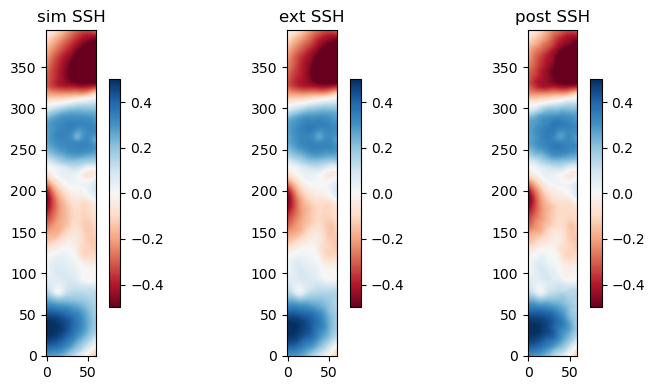

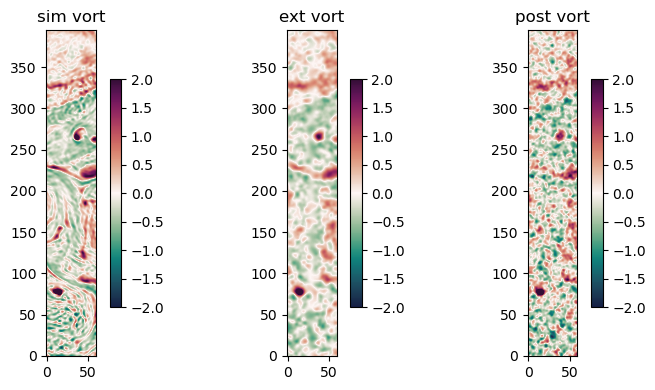

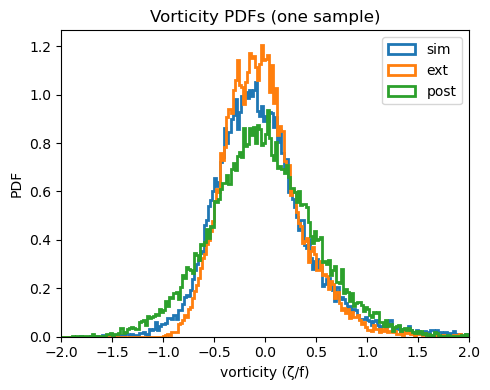

Standard deviations (relative to zero):
  sim :  0.5142
  ext :  0.4021
  post:  0.5319


In [2]:
import cmocean
fig, axes = plt.subplots(1, 3, figsize=(8,4))
fields = [ht_sim[t], ht_ext[t], ht_post]
titles = ["sim SSH", "ext SSH", f"post SSH"]

for ax, fld, ttl in zip(axes, fields, titles):
    im = ax.imshow(fld, origin="lower", cmap="RdBu", vmin = -0.5, vmax = 0.5)
    ax.set_title(ttl)
    fig.colorbar(im, ax=ax, shrink=0.7)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(8,4))
fields = [sim_vort, ext_vort, post_vort]
titles = ["sim vort", "ext vort", f"post vort"]

for ax, fld, ttl in zip(axes, fields, titles):
    im = ax.imshow(fld, origin="lower", cmap=cmocean.cm.curl, vmin = -2, vmax = 2)
    ax.set_title(ttl)
    fig.colorbar(im, ax=ax, shrink=0.7)
plt.tight_layout()
plt.show()

# Vorticity pdfs
def f(x):
    return x[np.isfinite(x)].ravel()

v_sim  = f(sim_vort)
v_ext  = f(ext_vort)
v_post = f(post_vort)

common_bins = np.linspace(-3, 3, 301)   # 300 bins between -2 and 2

plt.figure(figsize=(5,4))
plt.hist(v_sim,  bins=common_bins, histtype='step', density=True, linewidth=2, label='sim')
plt.hist(v_ext,  bins=common_bins, histtype='step', density=True, linewidth=2, label='ext')
plt.hist(v_post, bins=common_bins, histtype='step', density=True, linewidth=2, label='post')

plt.xlabel("vorticity (ζ/f)")
plt.ylabel("PDF")
plt.title("Vorticity PDFs (one sample)")
plt.xlim(-2, 2)
plt.legend()
plt.tight_layout()
plt.show()

print("Standard deviations (relative to zero):")
print(f"  sim :  {np.nanstd(v_sim):.4f}")
print(f"  ext :  {np.nanstd(v_ext):.4f}")
print(f"  post:  {np.nanstd(v_post):.4f}")

### Now read in our saved data over all times and samples 

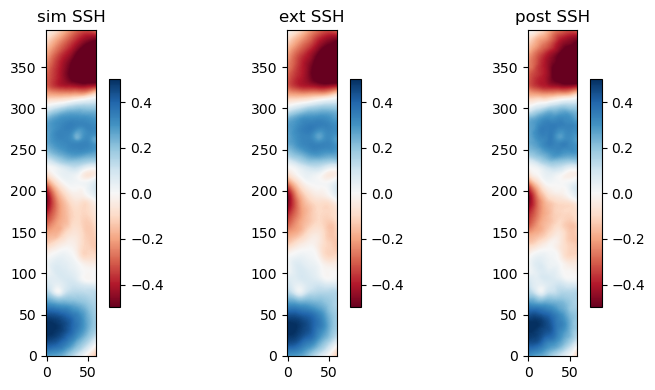

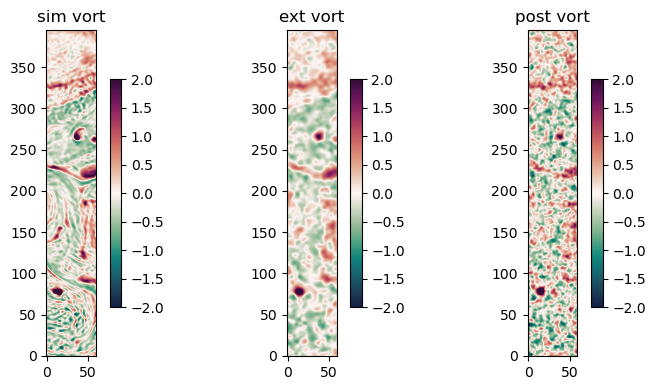

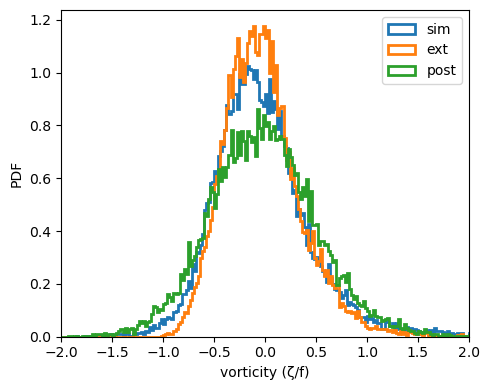

SSH variance (sim ) : 7.503638e-02
SSH variance (post) : 7.495081e-02
SSH variance (sim from above) : 6.823004e-02
SSH variance (post from above) : 7.545007e-02
Vorticity variance (sim ) : 2.721371e-01
Vorticity variance (post) : 2.914670e-01
Vorticity variance (sim from above) : 2.644035e-01
Vorticity variance (post from above) : 2.829021e-01
Vorticity std (sim ) : 0.52167
Vorticity std (post) : 0.53988
SSH post/sim variance ratio       : 0.999
Vorticity post/sim variance ratio : 1.071


In [5]:
#### Now we test the data that we saved before doing the extraction on it 

RESULTS_PATH = f"{PICKLES}/posterior_vorticity_results.pkl"  # computed posteriors in batch
results = load(RESULTS_PATH)
data = results[km]

read_ht_sim   = data['ssh_sim'][t, :, :]
read_ht_ext   = data['ssh_ext'][t, :, :]
read_ht_post  = data['ssh_post'][t, 0, :, :] # take one posterior sample
read_vort_sim = data['sim'][t, :, :]
read_vort_ext = data['ext'][t, :, :]
read_vort_post= data['post'][t, 0, :, :]

# ssh fields
fig, axes = plt.subplots(1, 3, figsize=(8,4))
fields = [read_ht_sim, read_ht_ext, read_ht_post] # ssh fields
titles = ["sim SSH", "ext SSH", "post SSH"]

for ax, fld, ttl in zip(axes, fields, titles):
    im = ax.imshow(fld, origin="lower", cmap="RdBu", vmin=-0.5, vmax=0.5)
    ax.set_title(ttl)
    fig.colorbar(im, ax=ax, shrink=0.7)

plt.tight_layout()
plt.show()

# vorticity fields
fig, axes = plt.subplots(1, 3, figsize=(8,4))
fields = [read_vort_sim, read_vort_ext, read_vort_post] # vorticity fields
titles = ["sim vort", "ext vort", "post vort"]

for ax, fld, ttl in zip(axes, fields, titles):
    im = ax.imshow(fld, origin="lower", cmap=cmocean.cm.curl, vmin=-2, vmax=2)
    ax.set_title(ttl)
    fig.colorbar(im, ax=ax, shrink=0.7)

plt.tight_layout()
plt.show()

# pdfs
read_vort_sim  = finite_flat(read_vort_sim)
read_vort_ext  = finite_flat(read_vort_ext)
read_vort_post = finite_flat(read_vort_post)

bins = np.linspace(-3, 3, 301)

plt.figure(figsize=(5,4))
plt.hist(read_vort_sim,  bins=bins, histtype='step', density=True, lw=2, label='sim')
plt.hist(read_vort_ext,  bins=bins, histtype='step', density=True, lw=2, label='ext')
plt.hist(read_vort_post, bins=bins, histtype='step', density=True, lw=2, label='post')
plt.xlim(-2, 2)
plt.xlabel("vorticity (ζ/f)")
plt.ylabel("PDF")
plt.legend()
plt.tight_layout()
plt.show()

print(f"SSH variance (sim ) : {np.nanvar(read_ht_sim):.6e}")
print(f"SSH variance (post) : {np.nanvar(read_ht_post):.6e}")
print(f"SSH variance (sim from above) : {np.nanvar(ht_sim):.6e}")
print(f"SSH variance (post from above) : {np.nanvar(ht_post):.6e}")

print(f"Vorticity variance (sim ) : {np.nanvar(read_vort_sim):.6e}")
print(f"Vorticity variance (post) : {np.nanvar(read_vort_post):.6e}")
print(f"Vorticity variance (sim from above) : {np.nanvar(sim_vort):.6e}")
print(f"Vorticity variance (post from above) : {np.nanvar(post_vort):.6e}")

print(f"Vorticity std (sim ) : {np.nanstd(read_vort_sim):.5f}")
print(f"Vorticity std (post) : {np.nanstd(read_vort_post):.5f}")

print(f"SSH post/sim variance ratio       : {np.nanvar(read_ht_post) / np.nanvar(read_ht_sim):.3f}")
print(f"Vorticity post/sim variance ratio : {np.nanvar(read_vort_post) / np.nanvar(read_vort_sim):.3f}")


dict_keys([0, 1, 2, 4, 8, 16])
Color limits: vmin=-2, vmax=2


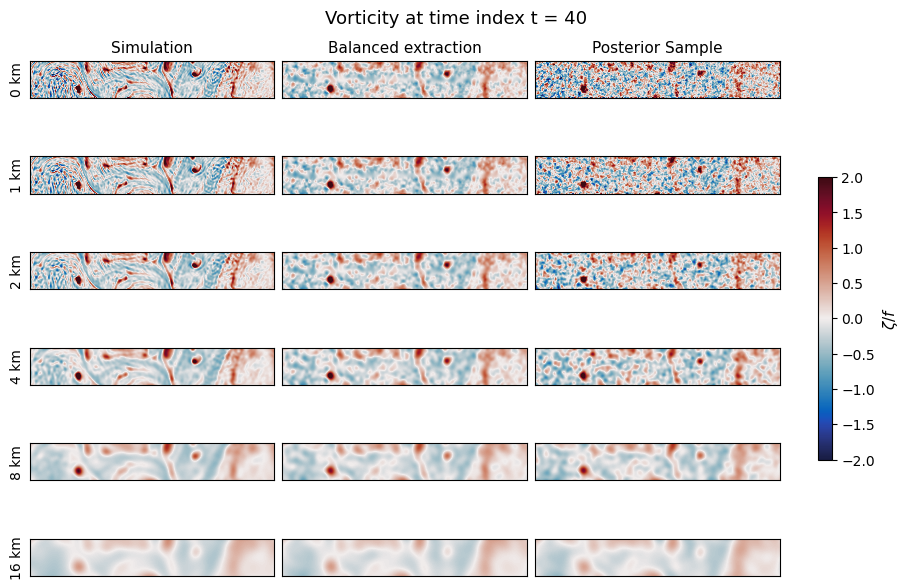

In [8]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cmocean

RESULTS_PATH = f"{PICKLES}/posterior_vorticity_results.pkl"

# -------------------------
# Load results dict
# -------------------------
def load(file): 
    with open(file, "rb") as f:
        results = pickle.load(f)
    return results

results = load(RESULTS_PATH)
print(results.keys())
# Scales and time/sample choices
SCALES = [0, 1, 2, 4, 8, 16]  # km
t_idx  = 40                   # time index to plot
use_posterior_mean = False    # True: mean over samples, False: pick one sample
s_idx  = 0                    # which sample if not using mean

# -------------------------
# Work out global color limits for all panels
# -------------------------
all_fields = []

for km in SCALES:
    sim_vort = results[km]["sim"][t_idx]          # (ny, nx)
    ext_vort = results[km]["ext"][t_idx]          # (ny, nx)
    if use_posterior_mean:
        post_vort = results[km]["post"][t_idx].mean(axis=0)  # (ny, nx)
    else:
        post_vort = results[km]["post"][t_idx, s_idx]        # (ny, nx)

    all_fields.extend([sim_vort, ext_vort, post_vort])

all_fields = np.stack(all_fields)
vmax = 2
vmin = -vmax

print(f"Color limits: vmin={vmin:.3g}, vmax={vmax:.3g}")

# -------------------------
# Make the panel plot
# -------------------------
n_scales = len(SCALES)
fig, axes = plt.subplots(
    n_scales, 3,
    figsize=(9, 1.0* n_scales),
    constrained_layout=True
)

# If only one scale, axes comes back 1D; make it 2D for uniform indexing
if n_scales == 1:
    axes = axes[np.newaxis, :]

titles = ["Simulation", "Balanced extraction", "Posterior Sample"]

im = None

for i, km in enumerate(SCALES):
    sim_vort = results[km]["sim"][t_idx]
    ext_vort = results[km]["ext"][t_idx]
    if use_posterior_mean:
        post_vort = results[km]["post"][t_idx].mean(axis=0)
    else:
        post_vort = results[km]["post"][t_idx, s_idx]

    fields = [sim_vort, ext_vort, post_vort]

    for j, (ax, field) in enumerate(zip(axes[i], fields)):
        im = ax.imshow(
            field.T,
            origin="lower",
            cmap=cmocean.cm.balance,
            vmin=vmin, vmax=vmax
        )
        if i == 0:
            ax.set_title(titles[j], fontsize=11)

        ax.set_xticks([])
        ax.set_yticks([])

        # Label the row by scale on the left
        if j == 0:
            ax.set_ylabel(f"{km} km", fontsize=10)

# One shared colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)
cbar.set_label(r"$\zeta/f$", fontsize=11)

fig.suptitle(f"Vorticity at time index t = {t_idx}", fontsize=13)
plt.savefig(f"vorticity_panels_t{t_idx}.png", dpi=150)
plt.show()


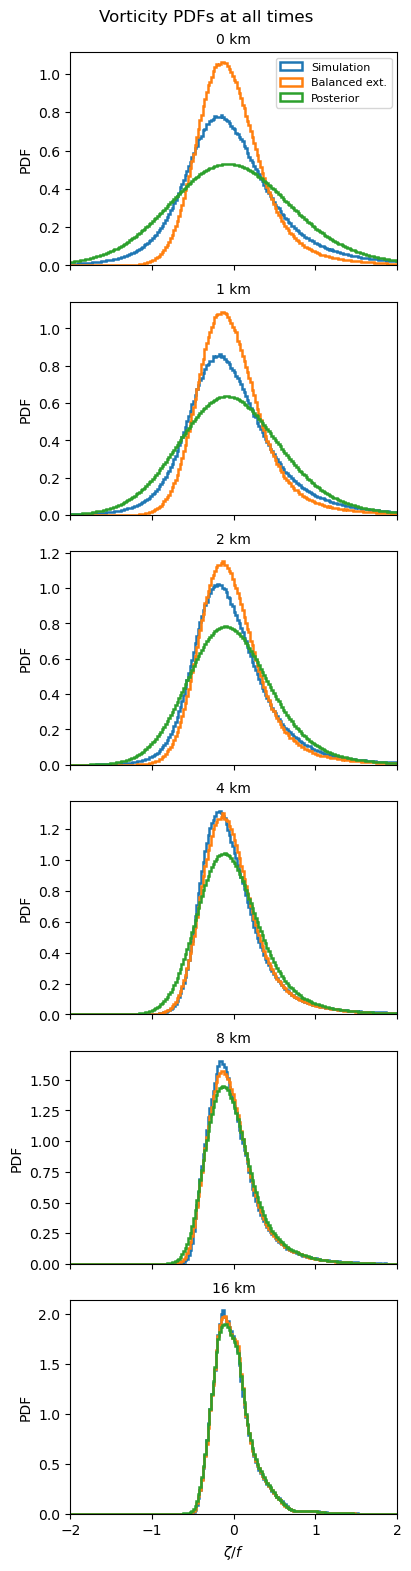

In [12]:
import numpy as np
import matplotlib.pyplot as plt

t_idx = 40   

fig, axes = plt.subplots(
    len(SCALES), 1,
    figsize=(4, 2.6 * len(SCALES)),
    sharex=True,
    constrained_layout=True
)

if len(SCALES) == 1:
    axes = [axes]

for ax, km in zip(axes, SCALES):
    sim  = results[km]["sim"].ravel()
    ext  = results[km]["ext"].ravel()
    post = results[km]["post"].ravel()     # all samples, all gridpoints

    ax.hist(sim,  bins=common_bins, density=True, histtype="step",
            linewidth=1.8, label="Simulation")
    ax.hist(ext,  bins=common_bins, density=True, histtype="step",
            linewidth=1.8, label="Balanced ext.")
    ax.hist(post, bins=common_bins, density=True, histtype="step",
            linewidth=1.8, label="Posterior")

    ax.set_ylabel("PDF")
    ax.set_ylim(bottom=0)
    ax.set_xlim(-2, 2)
    ax.set_title(f"{km} km", fontsize=10)

axes[-1].set_xlabel(r"$\zeta/f$")
axes[0].legend(loc="upper right", fontsize=8)

fig.suptitle(f"Vorticity PDFs at all times", fontsize=12)
plt.savefig(f"vorticity_pdfs_allt.png", dpi=150)
plt.show()


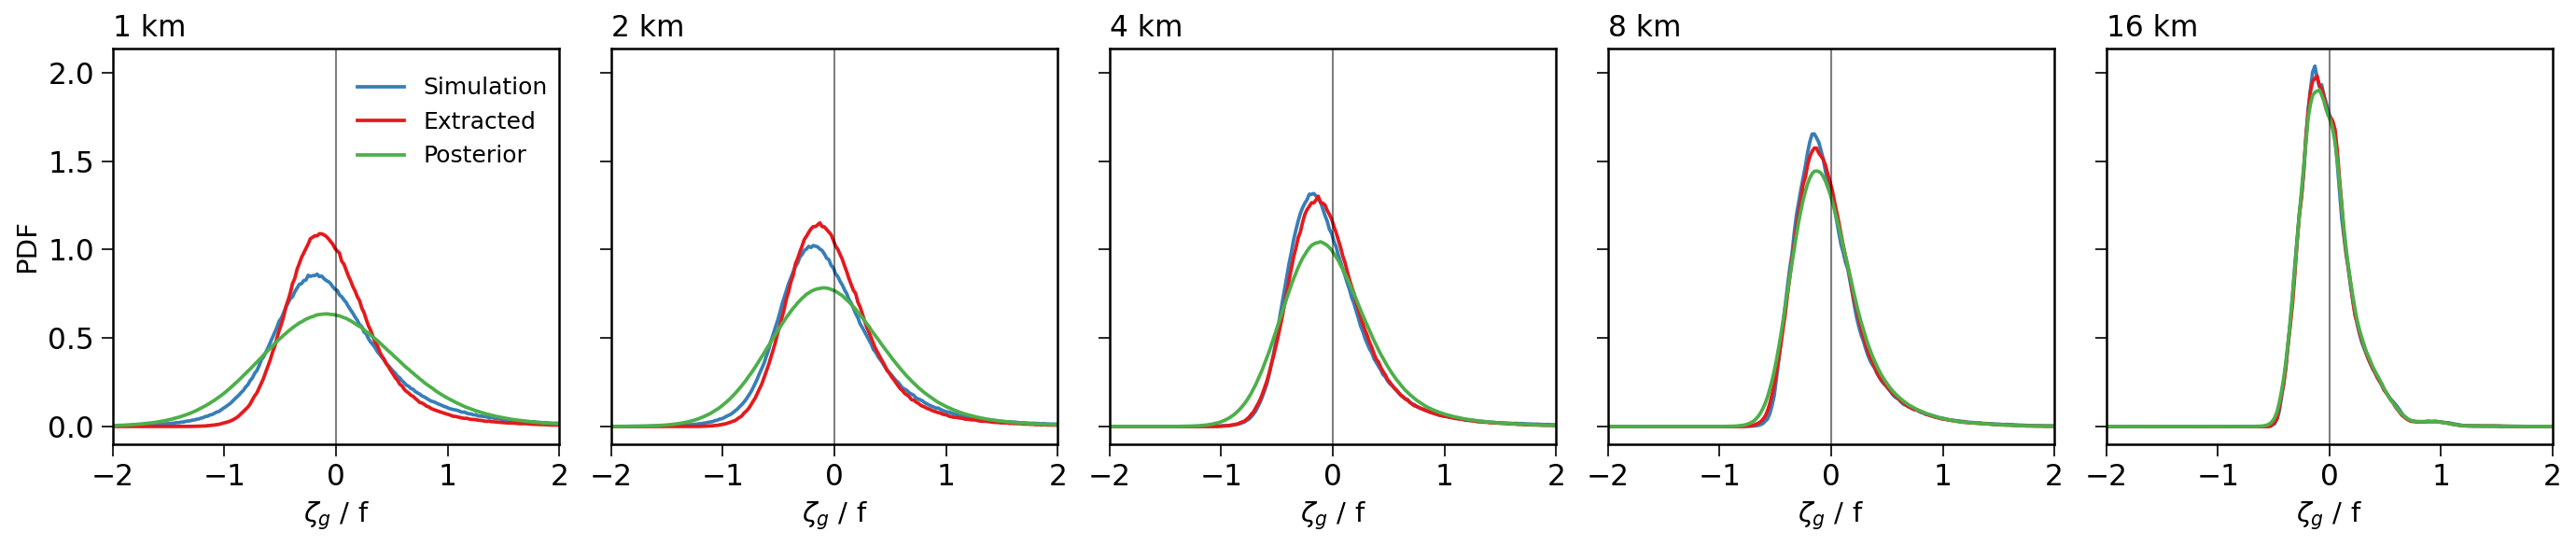

In [9]:
# Make the plot for Fig 11. 

swot.set_plot_style()

SCALES = [1, 2, 4, 8, 16] # drop the 0

def finite_flat_one(arr):
    v = np.asarray(arr, dtype=float).ravel()
    return v[np.isfinite(v)]

def pdf_shared_bins(*arrays, bins=300, lo=-3, hi=3):
    edges   = np.linspace(lo, hi, bins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])
    pdfs = []
    for arr in arrays:
        v = finite_flat_one(arr)
        v = v[(v >= lo) & (v <= hi)]
        h, _ = np.histogram(v, bins=edges, density=True)
        pdfs.append(h)
    return centers, pdfs

fig, axes = plt.subplots(
    1, len(SCALES),
    figsize=(3.7 * len(SCALES), 4.0),
    sharex=True, sharey=True,
    dpi=150
)

pdfs = {}

for ax, scale in zip(axes, SCALES):
    data = results[scale]
    
    x, (pdf_sim, pdf_ext, pdf_post) = pdf_shared_bins(
        data["sim"], data["ext"], data["post"],
        bins=300, lo=-3, hi=3
    )

    pdfs[scale] = (x, pdf_sim, pdf_ext, pdf_post)  # for moments later

    # Plot
    ax.plot(x, pdf_sim,  lw=1.8, label="Simulation")
    ax.plot(x, pdf_ext,  lw=1.8, label="Extracted")
    ax.plot(x, pdf_post, lw=1.8, label="Posterior")

    ax.set_xlim(-2.0, 2.0)
    ax.set_title(f"{scale} km", loc="left", fontsize=15)
    ax.set_xlabel(r"$\zeta_g$ / f", fontsize=14)
    ax.axvline(0, color="k", lw=1.0, ls="-", alpha=0.5)
    ax.tick_params(axis="both", which="major", labelsize=15)

axes[0].set_ylabel("PDF", fontsize=14)

# Shared legend
handles, labels = axes[-1].get_legend_handles_labels()
axes[0].legend(
    handles, labels,
    loc="upper right",
    frameon=False,
    fontsize=12,
    bbox_to_anchor=(1.02, 0.98)
)

fig.tight_layout()
plt.savefig("PDFS.pdf")
plt.show()

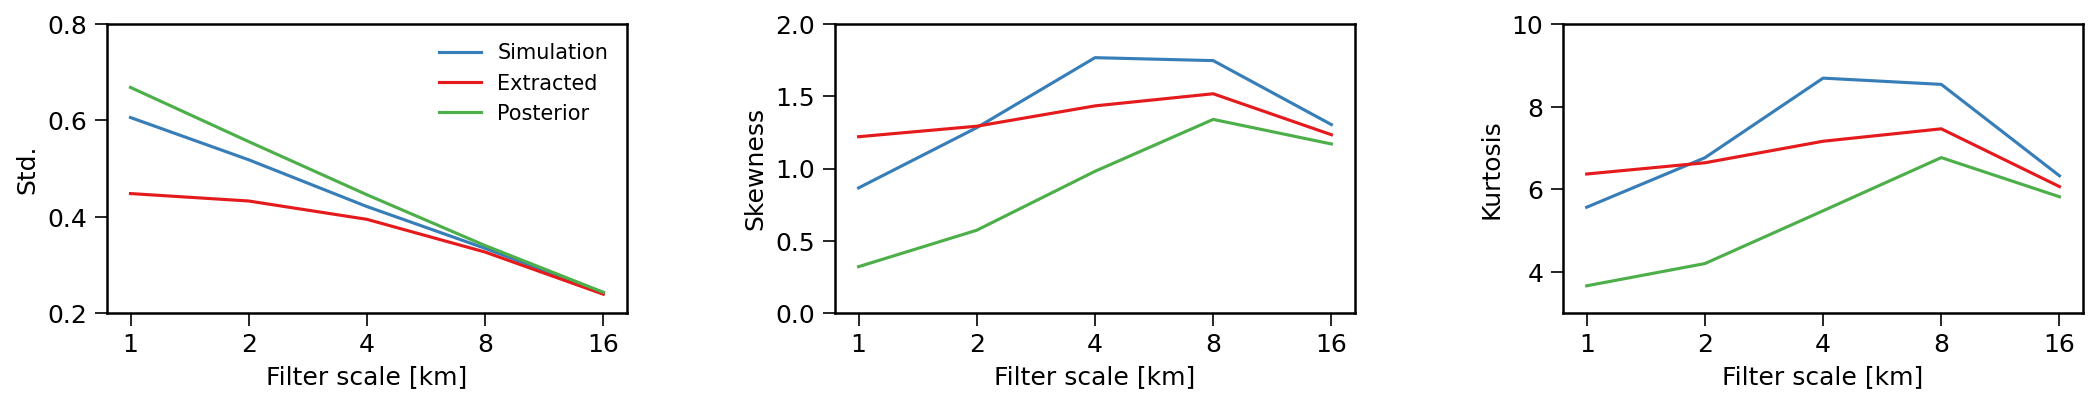

In [10]:
def hist_moments(x, p):
    dx = x[1] - x[0]
    w = p * dx
    m1 = np.sum(x * w)
    c = x - m1
    m2 = np.sum((c**2) * w)
    m3 = np.sum((c**3) * w)
    m4 = np.sum((c**4) * w)
    skew = m3 / (m2 ** 1.5)
    kurt = m4 / (m2 ** 2)
    return m1, m2, skew, kurt

scales = []
var_sim, var_ext, var_post = [], [], []
skw_sim, skw_ext, skw_post = [], [], []
kur_sim, kur_ext, kur_post = [], [], []

for km, (x, pdf_sim, pdf_ext, pdf_post) in pdfs.items():
    _, v_s, s_s, k_s = hist_moments(x, pdf_sim)
    _, v_e, s_e, k_e = hist_moments(x, pdf_ext)
    _, v_p, s_p, k_p = hist_moments(x, pdf_post)

    scales.append(km)
    var_sim.append(v_s); var_ext.append(v_e); var_post.append(v_p)
    skw_sim.append(s_s); skw_ext.append(s_e); skw_post.append(s_p)
    kur_sim.append(k_s); kur_ext.append(k_e); kur_post.append(k_p)
    
std_sim  = np.sqrt(var_sim)
std_ext  = np.sqrt(var_ext)
std_post = np.sqrt(var_post)

plt.figure(figsize=(17, 2.5), dpi=150)
ax1 = plt.subplot(1, 3, 1)
plt.subplots_adjust(wspace=0.4)
ax1.plot(scales, std_sim,  "-",lw=1.5, label="Simulation")
ax1.plot(scales, std_ext,  "-",lw=1.5, label="Extracted")
ax1.plot(scales, std_post, "-",lw=1.5, label="Posterior")
ax1.set_ylabel("Std.", fontsize=12)
ax1.tick_params(axis="both", labelsize=12)
ax1.legend(frameon=False, fontsize=10, ncols=1)
ax1.set_xticks(scales)
ax1.set_xticklabels(scales)
ax1.set_xlabel("Filter scale [km]", fontsize=12)
ax1.set_ylim(0.2, 0.8)

ax2 = plt.subplot(1, 3, 2, sharex=ax1)
ax2.plot(scales, skw_sim,  "-", lw=1.5)
ax2.plot(scales, skw_ext,  "-", lw=1.5)
ax2.plot(scales, skw_post, "-", lw=1.5)
ax2.set_ylabel("Skewness", fontsize=12)
ax2.set_xlabel("Filter scale [km]", fontsize=12)
ax2.tick_params(axis="both", labelsize=12)
ax2.set_ylim(0.0, 2.0)

ax3 = plt.subplot(1, 3, 3, sharex=ax1)
ax3.plot(scales, kur_sim,  "-", lw=1.5)
ax3.plot(scales, kur_ext,  "-", lw=1.5)
ax3.plot(scales, kur_post, "-", lw=1.5)
ax3.set_ylabel("Kurtosis", fontsize=12)
ax3.set_xlabel("Filter scale [km]", fontsize=12)
ax3.tick_params(axis="both", labelsize=12)
ax3.set_ylim(3, 10)

for ax in [ax1, ax2, ax3]:
    ax.set_xscale("log", base=2)
    ax.set_xticks(SCALES)
    ax.set_xticklabels([str(k) for k in SCALES])

plt.subplots_adjust(hspace=0.45)
#plt.tight_layout()
plt.savefig("vort-moments.pdf")
plt.show()

In [11]:
for km, (x, pdf_sim, pdf_ext, pdf_post) in pdfs.items():
    m_s, v_s, s_s, k_s = hist_moments(x, pdf_sim)
    m_e, v_e, s_e, k_e = hist_moments(x, pdf_ext)
    m_p, v_p, s_p, k_p = hist_moments(x, pdf_post)

    # ---- PRINT MOMENTS FOR THIS SCALE ----
    print(f"\n=== Scale {km} km ===")
    print(f" Simulation: mean={m_s:.4f}, var={v_s:.4f}, skew={s_s:.4f}, kurt={k_s:.4f}")
    print(f" Extracted : mean={m_e:.4f}, var={v_e:.4f}, skew={s_e:.4f}, kurt={k_e:.4f}")
    print(f" Posterior : mean={m_p:.4f}, var={v_p:.4f}, skew={s_p:.4f}, kurt={k_p:.4f}")

    scales.append(km)
    var_sim.append(v_s); var_ext.append(v_e); var_post.append(v_p)
    skw_sim.append(s_s); skw_ext.append(s_e); skw_post.append(s_p)
    kur_sim.append(k_s); kur_ext.append(k_e); kur_post.append(k_p)



=== Scale 1 km ===
 Simulation: mean=-0.0256, var=0.3671, skew=0.8657, kurt=5.5613
 Extracted : mean=-0.0122, var=0.2006, skew=1.2201, kurt=6.3665
 Posterior : mean=-0.0134, var=0.4469, skew=0.3200, kurt=3.6561

=== Scale 2 km ===
 Simulation: mean=-0.0186, var=0.2684, skew=1.2829, kurt=6.7605
 Extracted : mean=-0.0120, var=0.1870, skew=1.2930, kurt=6.6385
 Posterior : mean=-0.0123, var=0.3090, skew=0.5726, kurt=4.1952

=== Scale 4 km ===
 Simulation: mean=-0.0129, var=0.1772, skew=1.7676, kurt=8.6908
 Extracted : mean=-0.0115, var=0.1555, skew=1.4338, kurt=7.1608
 Posterior : mean=-0.0115, var=0.1984, skew=0.9806, kurt=5.4750

=== Scale 8 km ===
 Simulation: mean=-0.0107, var=0.1116, skew=1.7473, kurt=8.5392
 Extracted : mean=-0.0108, var=0.1065, skew=1.5177, kurt=7.4621
 Posterior : mean=-0.0105, var=0.1155, skew=1.3401, kurt=6.7642

=== Scale 16 km ===
 Simulation: mean=-0.0099, var=0.0585, skew=1.3041, kurt=6.3227
 Extracted : mean=-0.0099, var=0.0570, skew=1.2341, kurt=6.0614
 Po